<a href="https://colab.research.google.com/github/mpudig/MATH5271/blob/main/MATH5271_Lab_3_Aliasing_and_Wavelets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MATH5271 Lab 3

# Time Series Analysis (Part 2)

Welcome to the 3rd MATH5271 lab session. In this lab we will extend our knowledge of time series analysis disussing aliasing and wavelet analysis. By the end of this lab you should be able to

- Use ideas related to the Nyquvist frequency to understand aliased signals,
- Compute wavelet transforms of signals and interpret the frequency-time spectrogram.

## Google Colaboratory

We will run the python labs in [Google Colaboratory](colab.research.google.com). Google Colab is a web-based computational environment in which you can read, write, and execute interactive *notebooks* like the one you are reading. The python code runs on a virtual machine in the cloud, so you don't need to install python on your local machine. 

Before you begin the lab, you will need to [sign up](https://accounts.google.com/signup) for a free Google account. If you do not wish to sign up for a Google account, that's fine: you will still be able to read through the lab. You just won't be able to make edits or run any code. 

## Colaboratory and Google Drive

If you have a Google account, you can mount your Google drive within the Colab environment. This is not required to run the lab (figures and movies will be saved to the Colab virtual machine and played in your browser). But if you would like to save output you can do so by navigating to `drive/'My Drive'`

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# !ln -s "/gdrive/My Drive/" "/content/"'

## 1. Setup

Before we get started analysing some data we need to ensure we have the appropriate 'libraries' installed. You can think of these as opening a box of available tools. The .csv files we upload will be uploaded into a 'pandas' data frame. We will use the 'numpy' (numerical python) package to do some basic maths with the data and Matplotlib's 'pyplot' package to make some pretty graphs. 

In this lab we will use pywt - Wavelet Transforms in Python (pywavelets.readthedocs.io/en/latest/). 

There are many other packages and libraries avaialble freely in python. We will experiment with a few in this course but will only really scratch the surface. I will try to keep things as simple as possible so we can focus on understanding - rather than trouble shooting technical issues.

In [2]:
# import libraries
import pandas as pd

# Numerics
import numpy as np

# Plotting
import matplotlib.pyplot as plt

#Wavelets
import pywt

# plot figures in Colaboratory notebook
%matplotlib inline
 

## 2. Load Data

We will be using two data sets today. Hourly data from the coast fo Oregon and quarterly data from the Equatorial Pacific. 

The first is a data set from a Coastal Enduarance Array off the coast of Oregon in the US (https://datalab.marine.rutgers.edu/data-nuggets/waves-wind/). The CSV file for the data between July 2016 and October 2017 can be dowloaded directly into Colab.

The second data set is 'Nino3' which is the average temperature of a patch of the sea-surface in the equatorial Pacific (https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni). The particular data set is from a reconstruction by Rayner et al. (doi:10.1029/2002JD002670; see also https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino3/) and has been provided in a convenient format by Torrence and Compo (see below).

In [6]:
# Define the URLs where the data sets are stored
met_url = 'https://datalab.marine.rutgers.edu/wp-content/uploads/2020/07/E03_Endurance_met_waves.csv'
nino3_url = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"

# Import the data set as a Pandas Dataframe using the 'read_csv' function
df = pd.read_csv(met_url)
df_nino = pd.read_table(nino3_url)

## 3. Aliasing

Lets take a preliminary look at the air temperature of the Oregon coast met station. We will plot the entire time series, the first month and the first day seperately.

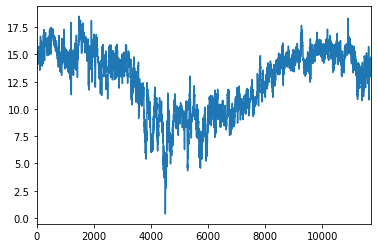

In [8]:
df['Air Temperature (deg_C)'].plot()

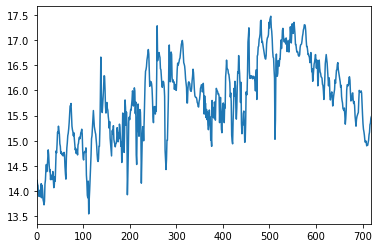

In [9]:
df['Air Temperature (deg_C)'].iloc[0:(24*30)].plot()

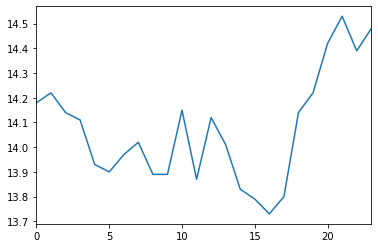

In [10]:
df['Air Temperature (deg_C)'].iloc[0:(24)].plot()

It looks like there are fluctuations at long time scales (oredr a year or 365*24 hours) and at the daily time scale. So let's compute the fourier series of this time series and look at the spectrogram.

Text(0.5, 0, 'Frequency (1/days)')

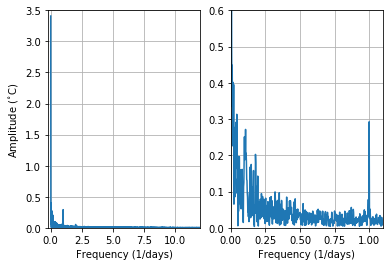

In [15]:
n = df.shape[0]
sp = np.fft.rfft(df['Air Temperature (deg_C)'],n)/(n/2)
plt.subplot(1,2,1)
plt.plot(np.arange(1,int(n/2))/(n/24),abs(sp[1:int(n/2)]))
plt.grid()
plt.axis([-0.2, 12, 0, 3.5])
plt.xlabel('Frequency (1/days)')
plt.ylabel('Amplitude ($^{\circ}$C)')
plt.subplot(1,2,2)
plt.plot(np.arange(1,int(n/2))/(n/24),abs(sp[1:int(n/2)]))
plt.grid()
plt.axis([0, 1.1, 0, 0.6])
plt.xlabel('Frequency (1/days)')

No let's think about the idea of aliasing put forward by Wilks in his time-series chapter. One of the results there was that if there is a signal at a frequency that is higher than the nyquvist frequency then that signal will be aliased. Let's say the aliased frequency is at $f_A$. *Measured in terms of the frequency of the observations (i.e. the time between 2 observations = 1)* the freqnecy at which the aliased freqnecy will appear in the periodogram will be $f$ where

$$ f_A = j \pm f $$

for $j$ a positive integer.

Let's try this out. Imagine you set temperature logger to record the temperature off the Oregon coast once a day. But there was a foult in the clock of the logger and it actually measure every 30 hours. Let's see what our spectrum would look like.

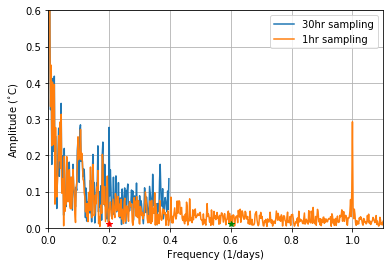

In [12]:
subsample = 30
tempsub = df['Air Temperature (deg_C)'].iloc[np.arange(0,n,subsample)]
nsub = tempsub.shape[0]
spsub = np.fft.rfft(tempsub,nsub)/(nsub/2)
plt.plot(np.arange(1,int(nsub/2))/(subsample*nsub/24),abs(spsub[1:int(nsub/2)]),label = '30hr sampling')
plt.plot(np.arange(1,int(n/2))/(n/24),abs(sp[1:int(n/2)]),label = '1hr sampling')
plt.axis([0, 1.1, 0, 0.6])
plt.grid()
plt.xlabel('Frequency (1/days)')
plt.ylabel('Amplitude ($^{\circ}$C)')
fA = subsample/24
f = fA-np.arange(1,5)
fdays = f*24/subsample
plt.plot(fdays,0*fdays+0.01,'r*')
plt.plot(-fdays,0*fdays+0.01,'g*')
plt.legend()

There are a lot of signals that have been aliased here but it looks like the biggest difference is at 0.2 days$^{-1}$. 

How does this work? Well the aliased signal is at $f_A$ = 1 days$^{-1}$. In terms of the sampling frequency of once every 30 hours $f_A =$ (30/1.25 hrs)$^{-1}$ = $1.25$ (30hrs)$^{-1}$. So if we choose $f_A = 1+f$ we get $f =$ 0.25(30hrs)$^{-1}$= 0.2day$^{-1}$. This is the red star in the graph above. 

Try changing the sampling frequqncy and see what integers are appropriate. 

Is a signal ever aliased at two points in the spectrum.

## 3. Wavelets

These excercises are inspired by: Torrence, Christopher, and Gilbert P. Compo. "A practical guide to wavelet analysis." Bulletin of the American Meteorological society 79.1 (1998): 61-78 https://paos.colorado.edu/research/wavelets.

Before we dive into computing the wavelet transform for the Nino3 data let's take a look at it and compute the regular periodogram.


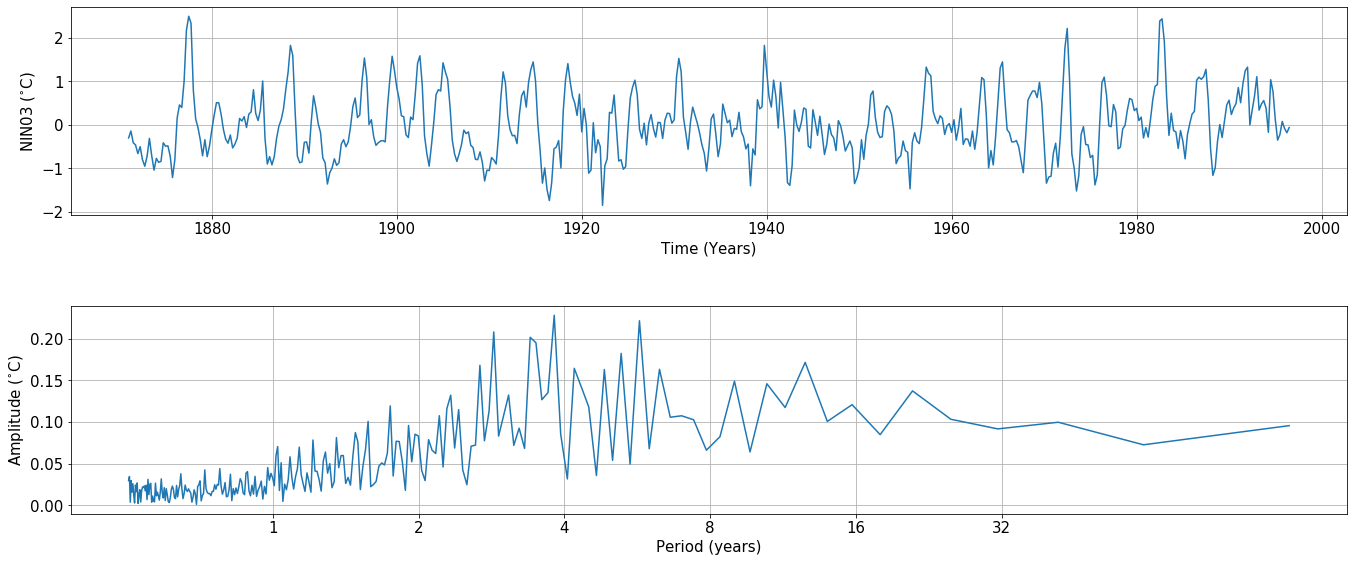

In [35]:
dt = 0.25 # years
t0 = 1871
n3 = df_nino.shape[0]
time = t0+np.arange(0,n3)*dt

fig, axs = plt.subplots(2, 1, figsize=(20,9))

ax = axs[0]
ax.plot(time,df_nino.values.squeeze())
ax.grid()
ax.set_ylabel('NIN03 ($^{\circ}$C)', fontsize=15)
ax.set_xlabel('Time (Years)', fontsize=15)
ax.tick_params(labelsize=15)

ax = axs[1]
sp = np.fft.rfft(df_nino.values.squeeze(),n3)/(n3/2)
fft_freq = np.arange(1,int(n3/2))/(n3*dt)
ax.plot(np.log2(1/fft_freq),abs(sp[1:int(n3/2)])) # log2(1/frequency) = log2(period)
yticks = [1,2,4,8,16,32];
ax.grid()
ax.set_xticks(ticks = np.log2(yticks))
ax.set_xticklabels(yticks)
ax.set_xlabel('Period (years)', fontsize=15)
ax.set_ylabel('Amplitude ($^{\circ}$C)', fontsize=15)
ax.tick_params(labelsize=15)

fig.tight_layout(pad=5.0)

Looking at the time series there are clearly a lot of variations at inter-annual (less than 10 years) frequencies. The periodogram (here shown in period rather than frequency) shows a lot of power at 3-7 years.

Your eye might tell you that it looks like the variability itself varies over time. You'd be forgiven for thinking there might be less ectivity at these timnescales in the middle of the data set.

Let make up a time series with a strong variation in variability and see if a wavelet approach would reveal it for us.

/Users/mattpudig/opt/anaconda3/lib/python3.7/site-packages/pywt/_cwt.py:74: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


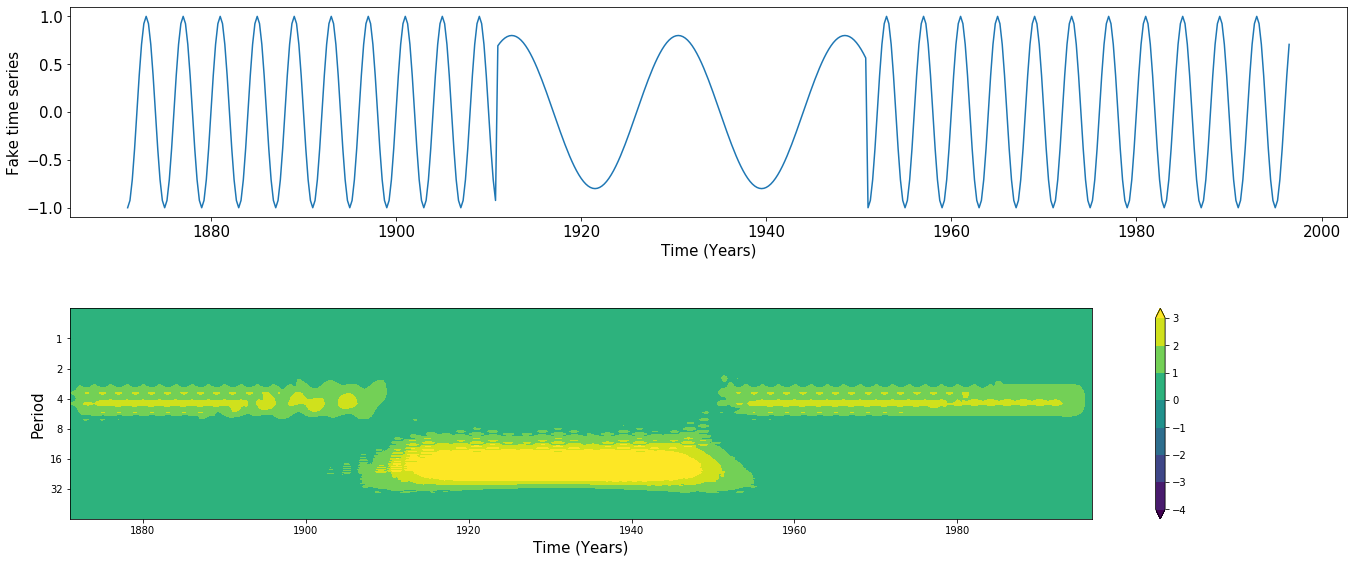

In [55]:
waveletname = 'cmor' # Complex Morelet Wavelet
scales = np.arange(1,128)
#data = np.sin(time*2*np.pi/4)
#data = np.sin(time*2*np.pi/(time[-1]))**2*np.sin(time*2*np.pi/4)
data = np.concatenate((np.sin(time[0:160]*2*np.pi/4),0.8*np.sin(time[160:320]*2*np.pi/18),np.sin(time[320:time.shape[0]]*2*np.pi/4)))
[coef, freqs] = pywt.cwt(data,scales,waveletname,dt)
power = (abs(coef))**2
period = 1./freqs
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)

fig, axs = plt.subplots(2, 1, figsize=(20,9))

ax = axs[0]
ax.plot(time,data)
ax.set_ylabel('Fake time series', fontsize=15)
ax.set_xlabel('Time (Years)', fontsize=15)
ax.tick_params(labelsize=15)

plt.contourf(time,np.log2(period),(power), contourlevels, extend='both');
yticks = [1,2,4,8,16,32];
plt.gca().invert_yaxis()
plt.yticks(ticks = np.log2(yticks), labels = yticks)
plt.colorbar()
plt.ylabel('Period', fontsize=15)
plt.xlabel('Time (Years)', fontsize=15)
ax.tick_params(labelsize=15)


fig.tight_layout(pad=5.0)

Now let's do the same thing but for the actual NINO3 data.

/Users/mattpudig/opt/anaconda3/lib/python3.7/site-packages/pywt/_cwt.py:74: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


Text(0.5, 0, 'Time (Years)')

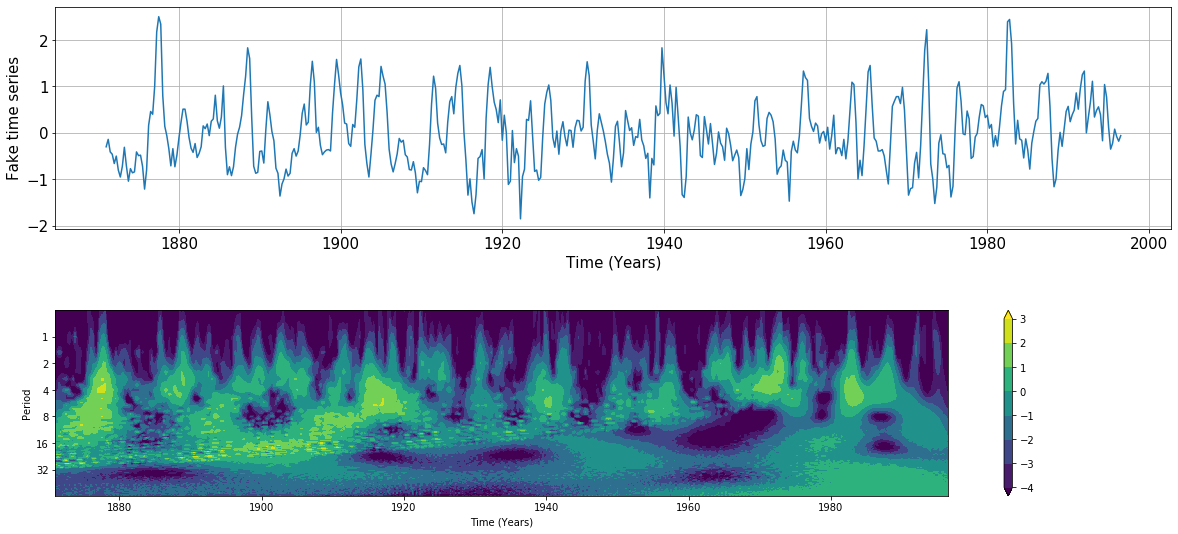

In [65]:
dt = 0.25 # 60*60 # 1 hour in seconds
time = 1871+np.arange(0,df_nino.shape[0])*dt
waveletname = 'cmor' # Complex Morelet Wavelet
scales = np.arange(1,128)
data = df_nino.values.squeeze()
[coef, freqs] = pywt.cwt(data,scales,waveletname,dt)
power = (abs(coef))**2
period = 1./freqs

# plt.subplot(5,1,(1,2))
# plt.plot(time,data)
# plt.ylabel('NINO3 ($^{\circ}$C)')
# plt.xlabel('Time (Years)')

fig, axs = plt.subplots(2, 1, figsize=(20,9))

ax = axs[0]
ax.plot(time,data)
ax.set_ylabel('Fake time series', fontsize=15)
ax.set_xlabel('Time (Years)', fontsize=15)
ax.tick_params(labelsize=15)
ax.grid()

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)
plt.subplot(5,1,(4,5))
plt.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both');
yticks = [1,2,4,8,16,32];
plt.gca().invert_yaxis()
plt.yticks(ticks = np.log2(yticks), labels = yticks)
plt.colorbar()
plt.ylabel('Period')
plt.xlabel('Time (Years)')

## 4. Exercise

Feel free to spend the Lab session working on Portfolio Task 1. 

Also consider trying some different data to apply wavelets too - such as the hourly wave data from Oregon. 
